Model şu cihazda çalışacak: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/71.5M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,0.802900,0.810488,0.671769,0.451273,0.671769,0.671769,0.539875,0.506050
2,0.793500,0.823998,0.671769,0.451273,0.671769,0.671769,0.539875,0.502514
3,0.777100,0.811730,0.671769,0.451273,0.671769,0.671769,0.539875,0.479511
4,0.794800,0.811410,0.671769,0.451273,0.671769,0.671769,0.539875,0.495654
5,0.799200,0.813361,0.671769,0.451273,0.671769,0.671769,0.539875,0.493303
6,0.780500,0.818113,0.671769,0.451273,0.671769,0.671769,0.539875,0.508215
7,0.785300,0.832025,0.671769,0.451273,0.671769,0.671769,0.539875,0.504150
8,0.784000,0.821582,0.671769,0.451273,0.671769,0.671769,0.539875,0.478504
9,0.776800,0.817971,0.671769,0.451273,0.671769,0.671769,0.539875,0.496704
10,0.787400,0.817048,0.671769,0.451273,0.671769,0.671769,0.539875,0.522313


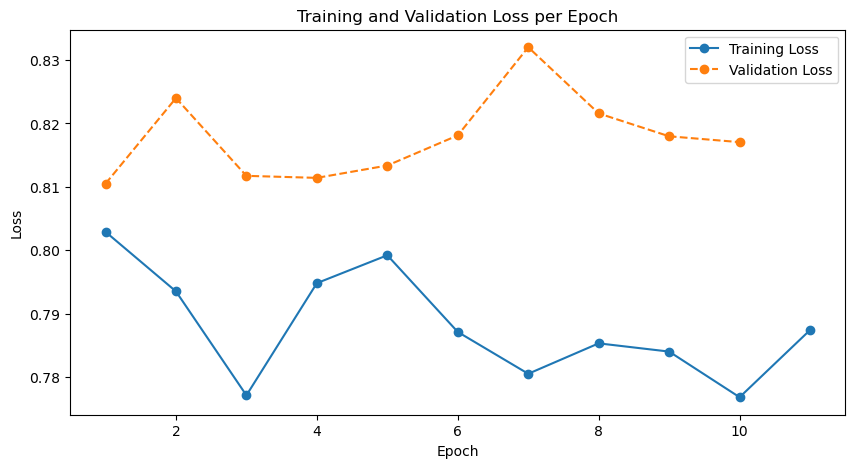

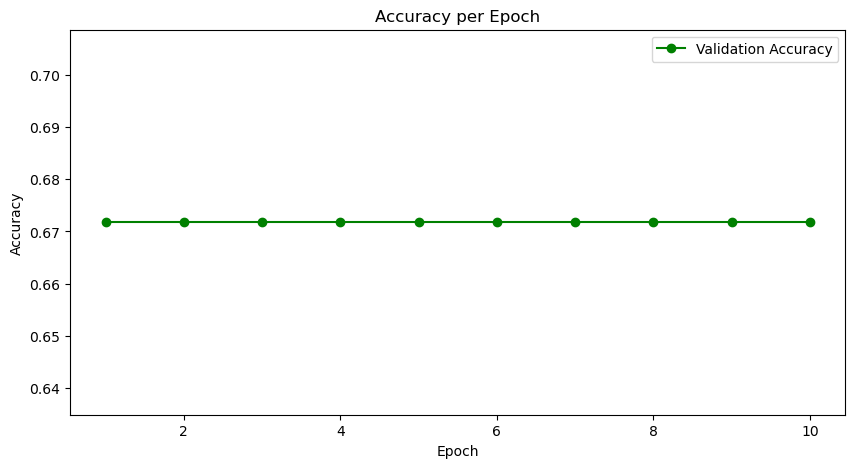

<Figure size 800x800 with 0 Axes>

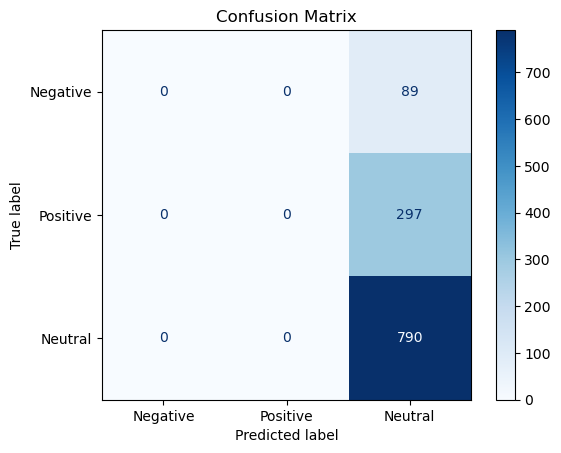

   test_loss  test_accuracy  test_precision  test_recall  test_specificity  \
0   0.817048       0.671769        0.451273     0.671769          0.671769   

    test_f1  test_auc  test_runtime  test_samples_per_second  \
0  0.539875  0.522313       23.3095                   50.452   

   test_steps_per_second  
0                  1.587  
AlBERT Large modeli ile eğitim ve değerlendirme tamamlandı!


In [3]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
from datasets import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

# GPU kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model şu cihazda çalışacak: {device}")

# Veri setini yükleme
data_cleaned = pd.read_csv("sentiment_analysis_results.csv")

# Etiketleri sayısal değere dönüştürme
label_map = {'positive': 1, 'negative': 0, 'neutral': 2}
data_cleaned['labels'] = data_cleaned['sentiment'].map(label_map)

# Eğitim ve test setlerine ayırma
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_cleaned['Yorum Temiz'].tolist(),
    data_cleaned['labels'].tolist(),
    test_size=0.2,
    random_state=42
)

# Model ismi ve Tokenizer tanımı (AlBERT Large modeli seçildi)
model_name = "albert-large-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=256)

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'labels': train_labels})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'labels': test_labels})

# Modeli tanımlama
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

# Eğitim ayarları
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.1,
    logging_dir="./logs",
    eval_strategy="epoch",
    fp16=True if torch.cuda.is_available() else False,
)

# Performans metriklerini hesaplama fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    probs = softmax(pred.predictions, axis=1)  # Softmax uygulandı
    preds = np.argmax(probs, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    try:
        auc = roc_auc_score(labels, probs, multi_class='ovr')
    except ValueError:
        auc = 0.5
    specificity = recall_score(labels, preds, average='weighted', zero_division=0)
    return {"accuracy": acc, "precision": precision, "recall": recall, "specificity": specificity, "f1": f1, "auc": auc}

# Trainer objesi ve model eğitimi
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# Eğitim sırasında kaydedilen metrikleri alın
metrics = trainer.state.log_history

# Loss ve Accuracy metriklerini ayıkla
training_loss = [m.get("loss", None) for m in metrics if "loss" in m]
validation_loss = [m.get("eval_loss", None) for m in metrics if "eval_loss" in m]
accuracy = [m.get("eval_accuracy", None) for m in metrics if "eval_accuracy" in m]

# Loss Grafiği
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(training_loss) + 1), training_loss, label="Training Loss", marker='o')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label="Validation Loss", marker='o', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig("loss_per_epoch.png")
plt.show()

# Accuracy Grafiği
valid_accuracy = [acc for acc in accuracy if acc is not None]
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(valid_accuracy) + 1), valid_accuracy, label="Validation Accuracy", color="green", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.savefig("accuracy_per_epoch.png")
plt.show()

# Confusion Matrix
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive", "Neutral"])
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# Metrix tablosunu yazdırma
results_df = pd.DataFrame(predictions.metrics, index=[0])
results_df.to_csv("albert_large_model_results.csv", index=False)
print(results_df)

print("AlBERT Large modeli ile eğitim ve değerlendirme tamamlandı!")
